In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn
from tqdm.auto import tqdm#show loop progress
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models


import argparse
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML

from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# print(os.listdir("../input"))

import time
from torchvision.models.inception import inception_v3
import numpy as np
from scipy.stats import entropy
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
import torch
from torch import nn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/cnn-c1-fashion-mnist/__results__.html
/kaggle/input/cnn-c1-fashion-mnist/__notebook__.ipynb
/kaggle/input/cnn-c1-fashion-mnist/__output__.json
/kaggle/input/cnn-c1-fashion-mnist/model.ckpt
/kaggle/input/cnn-c1-fashion-mnist/custom.css
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/processed/training.pt
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/processed/test.pt
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/t10k-labels-idx1-ubyte
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/t10k-images-idx3-ubyte
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/train-labels-idx1-ubyte
/kaggle/input/cnn-c1-fashion-mnist/data/FashionMNIST/raw/train-images-idx3-ubyte
/kaggle/input/cnn-c1-fashion-mnis

In [2]:
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn_c1 = CNN()
cnn_c1.load_state_dict(torch.load('../input/cnn-c1-fashion-mnist/model.ckpt'))
cnn_c1.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [3]:
def find_data(trainloader,epoch):
    with torch.no_grad():
        data = []
        for images in trainloader:
            images = images.to('cpu')
            #print(images.size())
            test = Variable(images.float())
            #print(test.size())
            outputs = cnn_c1(test)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(images)):
                data.append([images[i],predicted[i]])
    len(data)
    gan_testloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)
    torch.save(gan_testloader, './gan_data_epoch_{}'.format(epoch))

In [4]:
train_loader = torch.load('../input/fashion-mnist-for-dis-score/dis_score_loader')
#test_loader = torch.load('../input/mnist-splitter/svdash_dataloader')
len(train_loader)

625

In [5]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

train_loader = torch.load('../input/fashion-mnist-for-dis-score/dis_score_loader')
n_epochs = 201
batch_size= 64
lr=0.00005
n_cpu=2
latent_dim=100
n_critic=5
clip_value=0.01
n_classes=10
img_size=28
channels=1
sample_interval=400

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
#os.makedirs("../../data/mnist", exist_ok=True)
dataloader = train_loader
# torch.utils.data.DataLoader(
#     datasets.MNIST(
#         "../../data/mnist",
#         train=True,
#         download=True,
#         transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
#     ),
#     batch_size=batch_size,
#     shuffle=True,
# )

# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------
generated_images = []
psnr_score = []
mmd_score = []
fid_score = []
is_score= []
checkpoint = [1,10,20,30,40,50,100,150,200]
batches_done = 0
for epoch in range(n_epochs):
    fake_image_array = []
    real_array = []
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z).detach()
        
        if epoch in checkpoint:
            generated_images.append(fake_imgs)
            fake_image_array.append(fake_imgs)
            real_array.append(real_imgs)
        # Adversarial loss
        loss_D = -torch.mean(discriminator(real_imgs)) + torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = -torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )

        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "./%d.png" % batches_done, nrow=5, normalize=True)
        batches_done += 1
    if epoch in checkpoint:
        print("========E=======P========O========C=========H=======:",epoch)
        temp_image = []
        for curr in generated_images:
            for i in curr:
                temp_image.append(i)
        trainloader = torch.utils.data.DataLoader(temp_image, batch_size=64, shuffle=True)
        find_data(trainloader,epoch)
        generated_images = []


[Epoch 0/201] [Batch 0/625] [D loss: -0.020666] [G loss: -0.004368]
[Epoch 0/201] [Batch 5/625] [D loss: -0.039504] [G loss: -0.004994]
[Epoch 0/201] [Batch 10/625] [D loss: -0.133784] [G loss: -0.007277]
[Epoch 0/201] [Batch 15/625] [D loss: -0.282735] [G loss: -0.015769]
[Epoch 0/201] [Batch 20/625] [D loss: -0.468386] [G loss: -0.037336]
[Epoch 0/201] [Batch 25/625] [D loss: -0.737680] [G loss: -0.073634]
[Epoch 0/201] [Batch 30/625] [D loss: -0.867437] [G loss: -0.123060]
[Epoch 0/201] [Batch 35/625] [D loss: -1.198072] [G loss: -0.184008]
[Epoch 0/201] [Batch 40/625] [D loss: -1.395216] [G loss: -0.264522]
[Epoch 0/201] [Batch 45/625] [D loss: -1.490895] [G loss: -0.353880]
[Epoch 0/201] [Batch 50/625] [D loss: -1.502078] [G loss: -0.465465]
[Epoch 0/201] [Batch 55/625] [D loss: -1.811757] [G loss: -0.581541]
[Epoch 0/201] [Batch 60/625] [D loss: -2.018287] [G loss: -0.723727]
[Epoch 0/201] [Batch 65/625] [D loss: -1.974709] [G loss: -0.878600]
[Epoch 0/201] [Batch 70/625] [D loss

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


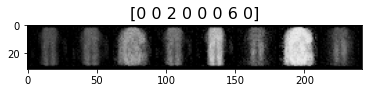

In [6]:
test = torch.load('./gan_data_epoch_1')
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for batch_idx, (temp, target) in enumerate(test):
    img_grid = make_grid(temp[0:8,], nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.detach().cpu().numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()